(vectorfield_visualization)=
# Визуализация векторного поля

Рассмотрим способы визуализации векторных и скалярных полей на примере электрического поля, создаваемого несколькими электрическими зарядами.

Как известно из курса физики, на _пробный заряд_ $Q$, помещённый в электрическое поле заряда $q_0$, действует сила Кулона:

$$
\mathbf{F}_0 =
    k \cfrac{q_0 Q}{(\mathbf{r} - \mathbf{r}_0)^2}
    \cfrac{\mathbf{r} - \mathbf{r}_0}{\| \mathbf{r} - \mathbf{r}_0 \|},
$$
где
$k$ - совокупность постоянных вида $k = 1 / (4 \pi \varepsilon_0)$;
$\varepsilon_0$ - диэлектрическая постоянная: $\varepsilon \approx 8.85419 \cdot 10^{-12}$ Ф$\cdot$м$^{-1}$;
$\mathbf{r}_0$ и $\mathbf{r}$ - координаты (радиус-векторы) зарядов $q_0$ и $Q$ соответственно.
Радиус-вектор в трёхмерном пространстве есть набор трёх координат:
$\mathbf{r} = (
    \begin{matrix}
        x & y & z
    \end{matrix}
).$

Электрическое поле, по определению, есть отношение электрической силы, действующей на заряд $Q$, при стремлении величины этого заряда к нулю:

$$
\mathbf{E}_0(\mathbf{r}) =
    \lim_{Q \rightarrow 0}{
        \cfrac{\mathbf{F}_0}{Q}
    } =
    k \cfrac{q_0}{(\mathbf{r} - \mathbf{r}_0)^2}
    \cfrac{\mathbf{r} - \mathbf{r}_0}{\| \mathbf{r} - \mathbf{r}_0 \|}.
$$
где $\mathbf{r}$ - радиус-вектор произвольной точки пространства, в которой требуется посчитать величину поля.

Электрическое поле может создаваться произвольным количеством $n$ зарядов $q_i$.
На рисунке ниже показана расчётная схема.
В этом случае результирующее поле рассчитывается, исходя из _принципа суперпозиции_ - суммарное поле есть сумма полей отдельных зарядов:

$$
\mathbf{E}(\mathbf{r}) =
    \sum\limits_{i=0}^{n-1}{\mathbf{E}_i(\mathbf{r})} =
    k \sum\limits_{i=0}^{n-1}{
        q_i \cfrac{\mathbf{r} - \mathbf{r}_0}{\| \mathbf{r} - \mathbf{r}_0 \|^3}
    }.
$$ (total_field)

![Расчётная схема](pics/charges_xy.png)

Электрическое поле - это _векторное поле_.
Это значит, что в каждой точке пространства $\mathbf{r}$ определена не только величина поля - электрическая напряжённость $E_0$, - но и его направление.
Именно вдоль направления поля $\mathbf{E}$ и действует сила Кулона.
Одним из способов визуализации любого векторного поля является построение его _силовых линий_.
Этим мы сейчас и займёмся - покажем векторное поле {eq}`total_field` для заданной системы зарядов.

## Визуализация векторного поля

С визуализацией нам поможет библиотека Matplotlib.

In [90]:
import matplotlib.pyplot as plt
# Для работы с массивами
import numpy as np
# Для векторной алгебры
import numpy.linalg as lina
# Вспомогательные константы
from scipy.constants import pi, epsilon_0

Инициализируем постоянную $k$ с программным именем `K` (переменная, набранная caps'ом, интерпретируется Python как постоянная):

In [91]:
K = 1 / (4*pi*epsilon_0)

### Расчёт поля двух зарядов

Программно опишем поле {eq}`total_field`:

In [92]:
def make_vector_field(qtopos):
    qs = qtopos[:, 0]
    rs = qtopos[:, [1, 2]]

    def field(mesh):
        mx, my = mesh
        r = np.vstack([mx.flatten(), my.flatten()])
        return K*superposition(qs, rs, r).reshape(np.shape(mesh))
    
    return field


def superposition(qs, rs, r):
    return np.sum([
        calc_partial_field(qi, ri, r)
        for qi, ri in zip(qs, rs)
    ], axis=0)


def calc_partial_field(qi, ri, r):
    dr = r.T - ri
    return qi*dr.T / lina.norm(dr, axis=1)**3

Данная функция принимает на вход массив зарядов `qs`, массив их координат `rs` и возвращает функцию `E`, зависящую только от `r` - координаты произвольной точки.
Функция `E` соответствует полю {eq}`total_field`.

### Создание расчётной сетки

Опишем функцию создания расчётной сетки в виде множества равномерно распределённых точек двумерного пространства $Oxy$.
В этом случае любой радиус-вектор состоит из двух компонент: $\mathbf{r} = (\begin{matrix} x & y \end{matrix})$.

In [93]:
def create_mesh(x_minmax: tuple, y_minmax: tuple, n: int):
    # Равномерно разбиваем оси
    x = np.linspace(*x_minmax, n)
    y = np.linspace(*y_minmax, n)
    # Создаём сетку
    return np.asarray(np.meshgrid(x, y))

Заодно создадим функцию визуализации сетки для лучшего её представления:

In [94]:
def plot_mesh_2d(mesh, figax=None, **kw):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    x, y = mesh
    ax.plot(x.flatten(), y.flatten(), ls="", **kw)
    ax.set(xlabel="$x$, м", ylabel="$y$, м")
    return fig, ax

На созданной с помощью `create_mesh` сетке (в её точках) мы и будем считать электрическое поле.

### Исходные данные

Для начала расмотрим электрическое поле, создаваемое двумя одинаковыми зарядами с противоположными знаками:

In [95]:
# Зададим размеры расчётной области:
# - по оси x: от -2 м до 2 м;
# - по оси y: от -2 м до 2 м
x_minmax = -2, 2
y_minmax = -2, 2
# Поместим 2 заряда: слева +1, справа -1
# и расположим их в точках (-1; 0) и (1; 0)
qtopos = np.vstack([
    [1, -1, 0],
    [-1, 1, 0]
])

Готово.
Можно переходить к расчёту.

### Расчёт поля

Сперва необходимо построить расчётную сетку (расчётные точки):

In [96]:
# Создадим расчётную сетку, разбив оси x и y на 20 точек
mesh = create_mesh(x_minmax, y_minmax, n=20)

Отобразим расчётные точки для проверки корректности сетки:

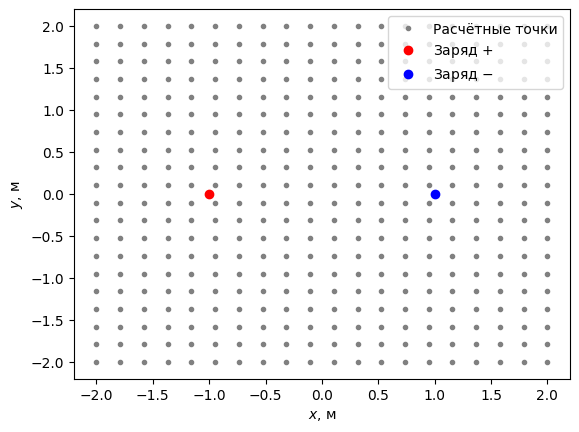

In [97]:
fig, ax = plot_mesh_2d(
    mesh, c="grey", marker=".", label="Расчётные точки"
)
# Заодно покажем расположение зарядов
ax.plot(
    *qtopos[0, [1, 2]], ls="", c="red", marker="o", label="Заряд $+$"
)
ax.plot(
    *qtopos[1, [1, 2]], ls="", c="blue", marker="o", label="Заряд $-$"
)
ax.legend(loc="upper right");

В серых точках и будет рассчитано векторное поле $\mathbf{E}$:

In [98]:
# Рассчитываем поле
E = make_vector_field(qtopos)
Ex, Ey = E(mesh)
print("Например, (Ex; Ey) в левой нижней точке:",
      (Ex[0, 0], Ey[0, 0]))

Например, (Ex; Ey) в левой нижней точке: (-228632984.6497247, -1224250083.568939)


Поле рассчитано.
Теперь его можно визуализировать.

### Визуализация

За отрисовку векторных полей в Matplotlib отвечает функция [streamplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.streamplot.html):

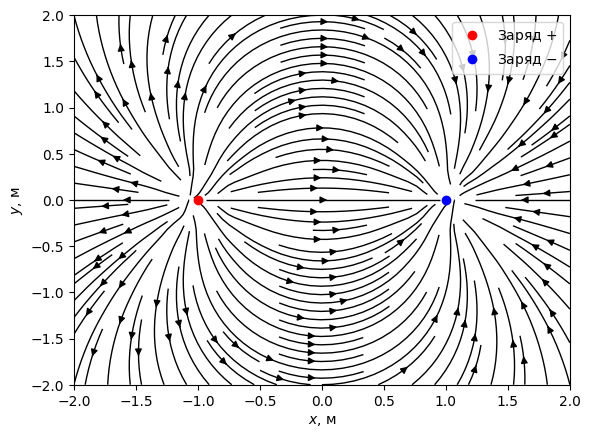

In [99]:
fig, ax = plt.subplots()
mx, my = mesh
# Силовые линии
ax.streamplot(
    mx, my, Ex, Ey,
    density=1.5, color="k", linewidth=1
)
# Сами заряды
ax.plot(
    *qtopos[0, [1, 2]], ls="", c="red", marker="o", label="Заряд $+$"
)
ax.plot(
    *qtopos[1, [1, 2]], ls="", c="blue", marker="o", label="Заряд $-$"
)
# И для красоты
ax.set(
    xlabel="$x$, м", ylabel="$y$, м"
)
ax.legend(loc="upper right");

Получили вполне непохую картину - силовые линии поля выходят из положительного заряда и входят в заряд отрицательный.

### Поле четырёх зарядов

В качестве дополнительного примера рассмотрим случай четырёх зарядов - двух положительных и двух отрицательных.

Исходные данные:

In [100]:
# Зададим размеры расчётной области:
# - по оси x: от -2 м до 2 м;
# - по оси y: от -2 м до 2 м
x_minmax = -2, 2
y_minmax = -2, 2
# Разместим 4 заряда в форме креста:
# - отрицательные заряды - по вертикали;
# - положительные - по горизонтали
qtopos = np.array([
    [-1, -1, 0],
    [-1, 1, 0],
    [1, 0, -1],
    [1, 0, 1]
])

Рассчитываем поле:

In [101]:
# Создадим расчётную сетку, разбив оси x и y на 50 точек
mesh = create_mesh(x_minmax, y_minmax, n=50)
# Считаем поле в узлах сетки
E = make_vector_field(qtopos)

Строим график:

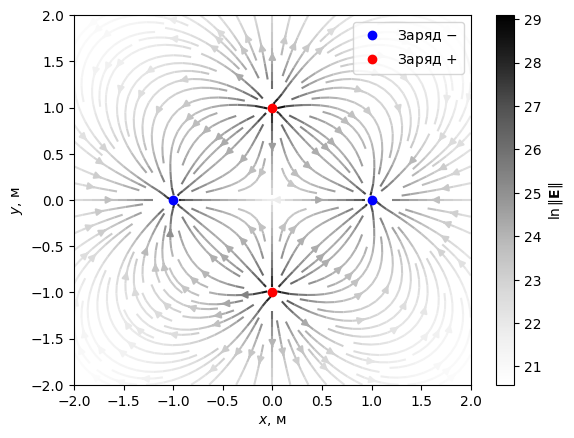

In [102]:
def plot_vectorfield_2d(mesh, field,
                        figax=None, cbar_label="", **kw):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig, ax
    mx, my = mesh
    fx, fy = field
    if "cmap" in kw:
        stream = ax.streamplot(mx, my, fx, fy, **kw)
        fig.colorbar(stream.lines, ax=ax, label=cbar_label)
        return fig, ax
    ax.streamplot(mx, my, fx, fy, **kw)
    return fig, ax


# Для визуализации величины поля сделаем цвет линий
# пропорциональным ей
field = E(mesh)
Ex, Ey = field
color = np.log(np.sqrt(Ex**2 + Ey**2))
# Силовые линии
_, ax = plot_vectorfield_2d(
    mesh,
    field,
    density=1.5,
    color=color,
    cmap="Greys",
    cbar_label=r"$\ln{\| \mathbf{E} \|}$"
)
# Сами заряды
ax.plot(
    qtopos[:2, 1], qtopos[:2, 2],
    ls="", c="blue", marker="o", label="Заряд $-$"
)
ax.plot(
    qtopos[2:, 1], qtopos[2:, 2],
    ls="", c="red", marker="o", label="Заряд $+$"
)
# И для красоты
ax.set(xlabel="$x$, м", ylabel="$y$, м")
ax.legend(loc="upper right");

Сведём созданный функциональный код воедино и поместим его в файл _vectorfield.py_:

```python

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lina
from scipy.constants import pi, epsilon_0


K = 1 / (4*pi*epsilon_0)


def make_vector_field(qtopos):
    """Возвращает функцию поля `E(mesh)`.
    
    * `qtopos` - массив размера `n` на `3`, где в
      каждая из `n` строк имеет вид
      `(qi, xi, yi)`.
    """
    qs = qtopos[:, 0]
    rs = qtopos[:, [1, 2]]

    def field(mesh):
        mx, my = mesh
        r = np.vstack([mx.flatten(), my.flatten()])
        return K*_superposition(qs, rs, r).reshape(np.shape(mesh))
    
    return field


# Функции, имена которых начинаются с нижнего подчёркивания,
# предназначены для использования только внутри модуля,
# в котором они объявлены, но не вне его -
# это своего рода приватные функции
def _superposition(qs, rs, r):
    return np.sum([
        _calc_partial_field(qi, ri, r)
        for qi, ri in zip(qs, rs)
    ], axis=0)


def _calc_partial_field(qi, ri, r):
    dr = r.T - ri
    return qi*dr.T / lina.norm(dr, axis=1)**3


def create_mesh(x_minmax: tuple, y_minmax: tuple, n_xy: tuple):
    """Равномерно расположить расчётные точки на осях.
    
    * `x_minmax` и `y_minmax` - границы области
      по соответствующим осям.
    * `n_xy` - число точек по соответствующим осям.

    Возвращает расчётную сетку, созданную как `np.meshgrid`.
    """
    x = np.linspace(*x_minmax, n_xy[0])
    y = np.linspace(*y_minmax, n_xy[1])
    return np.asarray(np.meshgrid(x, y))


def plot_mesh_2d(mesh, figax=None, **kw):
    """Визуализировать двумерную расчётную сетку.
    
    * `mesh` - расчётная сетка.
    * `figax` - кортеж вида `(figure, axis)`.
      По умолчанию `None`.
    
    Возвращает кортеж `(figure, axis)`.
    """
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    x, y = mesh
    ax.plot(x.flatten(), y.flatten(), ls="", **kw)
    ax.set(xlabel="$x$, м", ylabel="$y$, м")
    return fig, ax


def plot_vectorfield_2d(mesh, field,
                        figax=None, cbar_label="", **kw):
    """Визуализировать векторное поле `field`.
    
    * `mesh` - двумерная расчётная сетка.
    * `field` - двумерное векторное поле.
    * `figax` - кортеж вида `(figure, axis)`.
    * `cbar_label` - название цветовой шкалы, если она есть.

    Возвращает кортеж вида `(figure, axis)`.
    """
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    mx, my = mesh
    fx, fy = field
    if "cmap" in kw and cbar_label is not None:
        stream = ax.streamplot(mx, my, fx, fy, **kw)
        fig.colorbar(stream.lines, ax=ax, label=cbar_label)
        return fig, ax
    ax.streamplot(mx, my, fx, fy, **kw)
    return fig, ax


# Дополнительно опишем функцию отрисовки зарядов
def plot_charges(qtopos: dict, figax=None):
    """Отобразить заряды.
    
    * `qtopos` - словарь, ключом которого является
      величина заряда `qi`, а значением -
      координата заряда `(xi, yi)`.
    * `figax` - кортеж вида `(figure, axis)`.

    Возвращает кортеж вида `(figure, axis)`.
    """
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    kw_positive = dict(c="r", ls="", marker=".")
    kw_negative = dict(c="b", ls="", marker=".")
    ax.plot([], [], label="Заряд $+$", **kw_positive)
    ax.plot([], [], label="Заряд $-$", **kw_negative)
    for qi, xi, yi in qtopos:
        kw = kw_positive if qi > 0 else kw_negative
        ax.plot(xi, yi, **kw)
    return fig, ax

```

## Упражнения

1. ...